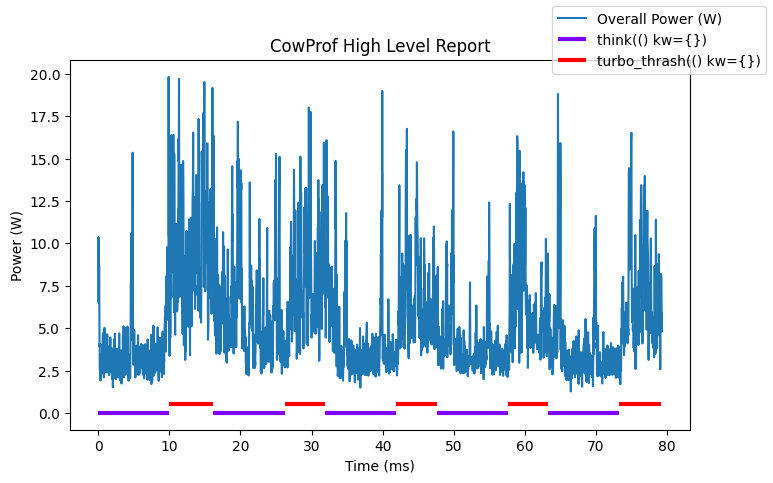

In [27]:
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# getting the power usage statistics

powerdata = "data\power-logs\PowerLog-2023-04-07 14-03-06.295516"

pwr = pl.read_csv(powerdata)

pwr = pwr.with_columns([
    pl.col("System Time")
    .str.strptime(pl.Time, fmt="%H:%M:%S:%f",strict=False)
    .cast(pl.Time, strict=False),    
])

#getting the timing statistics
timedata = "data\\intervals\\temp.csv"
timing = pl.read_csv(timedata)

# filtering and understanding timing data
timing = timing.with_columns([
    pl.cumsum('runtime').alias("Start") - pl.col('runtime'),
    pl.cumsum('runtime').alias("End"), 
])

fig, ax = plt.subplots()

timeline = pwr.select(
    pl.col("Elapsed Time (sec)"
))


# plot per sample energy data
ax.plot(timeline, pwr.select(pl.col("Processor Power_0(Watt)")), label= "Overall Power (W)")

# get the different unique function headers that are being tracked
uniqueheads = set(
    timing.select(
        pl.col(
            ["func-head"]
        )
    ).to_series()
    .to_list()
)


# unique colorings for each unique function call
# Gotten from here: https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib
pairings, shift = {}, 0
color = iter(cm.rainbow(np.linspace(0, 1, len(uniqueheads))))
for item in uniqueheads:
    pairings[item] = [next(color), shift]
    shift += 0.5
   
# plot the different functions and where they be
for row in timing.rows(named=True):
    func_name = row["func-head"]
    unique_color, unique_offset = pairings[func_name]
    plt.hlines(unique_offset, 
        row["Start"], 
        row["End"], 
        label=row["func-head"], 
        color=unique_color,
        linewidth=3)

# only use unique labels for repeat func calls
# from this blog post: https://itecnote.com/tecnote/python-stop-matplotlib-repeating-labels-in-legend/
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.title("CowProf High Level Report")
plt.xlabel("Time (ms)"); plt.ylabel("Power (W)")
fig.legend(by_label.values(), by_label.keys())
fig.set_figwidth(8)

#------------------------------------------------------------------------
